In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as sts
import psycopg2 as pg2

from sqlalchemy import create_engine

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Set db variables
user = 'anthony'
pw = 'pw'
host = 'localhost:5432'
db_name = 'indicator_tests'

# Create engine for interacting with db
engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}/{db_name}')

### Get NASDAQ ETF list :


In [3]:
nas_etf = pd.read_csv('../data/NAS_ETF_List.csv')

In [4]:
nas_etf = nas_etf['Symbol'].to_list()

In [111]:
# nas_etf[:10]

### SMA Entries

In [6]:
sma_nas = pd.read_sql_query(f'''SELECT ticker, sma_win
                                FROM sma_nasdaq
                                WHERE sma_buy = 1''',
                            con=engine)

In [7]:
# Note: some tickers are None
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043 entries, 0 to 3042
Data columns (total 2 columns):
ticker     3035 non-null object
sma_win    3043 non-null int64
dtypes: int64(1), object(1)
memory usage: 47.7+ KB


In [8]:
sma_nas.dropna(inplace=True)

In [9]:
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3035 entries, 0 to 3042
Data columns (total 2 columns):
ticker     3035 non-null object
sma_win    3035 non-null int64
dtypes: int64(1), object(1)
memory usage: 71.1+ KB


In [10]:
# Remove ETFs if exist
sma_nas = sma_nas[~sma_nas.ticker.isin(nas_etf)]

In [11]:
sma_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2976 entries, 0 to 3042
Data columns (total 2 columns):
ticker     2976 non-null object
sma_win    2976 non-null int64
dtypes: int64(1), object(1)
memory usage: 69.8+ KB


In [12]:
sma_nas.head()

,ticker,sma_win
0,MVIS,0
1,MVIS,0
2,MVIS,1
3,MVIS,1
4,MVIS,0


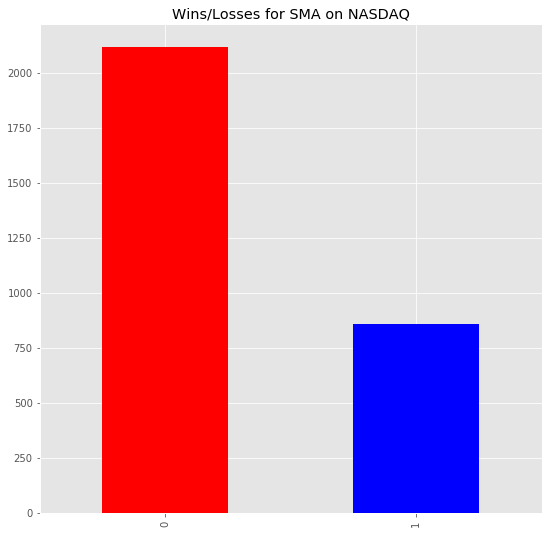

In [13]:
ax = sma_nas.sma_win.value_counts().plot(kind='bar',
                                         figsize=(9,9),
                                         title= 'Wins/Losses for SMA on NASDAQ',
                                         color=['red', 'blue']
                                        )

In [14]:
wins = sma_nas.sma_win.value_counts()[1]
losses = sma_nas.sma_win.value_counts()[0]
sma_mean = sma_nas.loc[:,"sma_win"].mean()
std = sma_nas.loc[:,"sma_win"].std()
sma_se = std / np.sqrt(wins+losses)
print(f'wins: {wins}\nlosses: {losses}\nmean: {sma_mean}\nstd: {std}\nse: {sma_se}')

wins: 859
losses: 2117
mean: 0.28864247311827956
std: 0.4532074730674296
se: 0.008307696053932029


Text(0, 0.5, 'Observations')

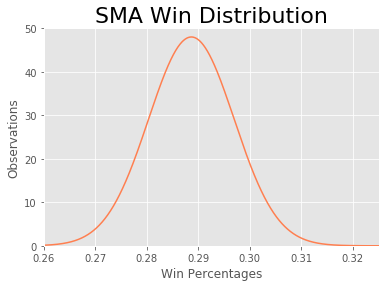

In [15]:
x_min = 0.26
x_max = 0.325

mean = sma_mean 
std = sma_se

x = np.linspace(x_min, x_max, wins+losses)

y = sts.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.xlim(x_min,x_max)
plt.ylim(0,50)

plt.title('SMA Win Distribution',fontsize=22)

plt.xlabel('Win Percentages')
plt.ylabel('Observations')

### Random Entries

In [16]:
rnd_nas = pd.read_sql_query(f'''SELECT ticker, rnd_win
                                FROM sma_nasdaq
                                WHERE rnd_buy = 1''',
                            con=engine)

In [17]:
rnd_nas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 2 columns):
ticker     2986 non-null object
rnd_win    2986 non-null int64
dtypes: int64(1), object(1)
memory usage: 46.8+ KB


In [18]:
# Remove ETFs if exist
rnd_nas = rnd_nas[~rnd_nas.ticker.isin(nas_etf)]

In [19]:
rnd_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2985
Data columns (total 2 columns):
ticker     2930 non-null object
rnd_win    2930 non-null int64
dtypes: int64(1), object(1)
memory usage: 68.7+ KB


In [20]:
rnd_nas.head()

,ticker,rnd_win
0,MVIS,0
1,MVIS,1
2,MVIS,1
3,MVIS,0
4,MVIS,0


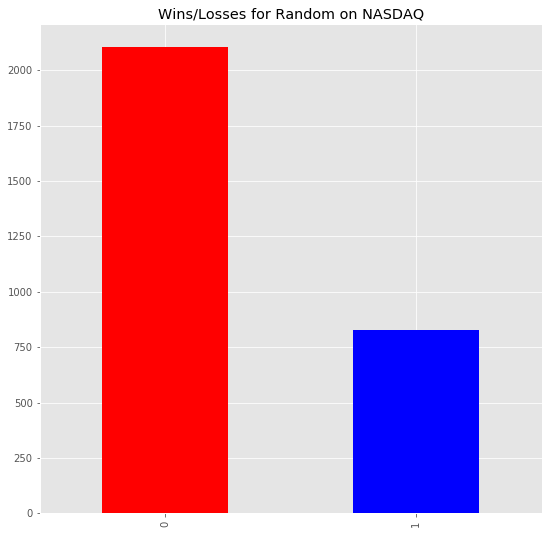

In [21]:
ax = rnd_nas.rnd_win.value_counts().plot(kind='bar',
                                         figsize=(9,9),
                                         title= 'Wins/Losses for Random on NASDAQ',
                                         color=['red', 'blue']
                                        )

In [22]:
wins = rnd_nas.rnd_win.value_counts()[1]
losses = rnd_nas.rnd_win.value_counts()[0]
rnd_mean = rnd_nas.loc[:,"rnd_win"].mean()
std = rnd_nas.loc[:,"rnd_win"].std()
rnd_se = std / np.sqrt(wins+losses)
print(f'wins: {wins}\nlosses: {losses}\nmean: {rnd_mean}\nstd: {std}\nse: {rnd_se}')

wins: 827
losses: 2103
mean: 0.28225255972696245
std: 0.45017243125041223
se: 0.008316586040225485


Text(0, 0.5, 'Observations')

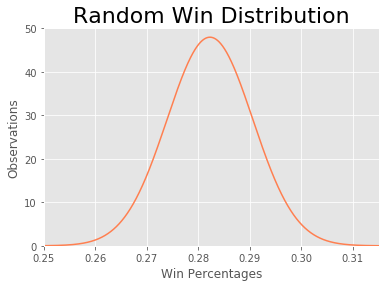

In [23]:
x_min = 0.25
x_max = 0.315

mean = rnd_mean 
std = rnd_se

x = np.linspace(x_min, x_max, wins+losses)

y = sts.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')

plt.xlim(x_min,x_max)
plt.ylim(0,50)

plt.title('Random Win Distribution',fontsize=22)

plt.xlabel('Win Percentages')
plt.ylabel('Observations')

In [104]:
def plot_power(H0, HA, alpha=.05, force_n=None, one_tailed=True, figsize=(20,20)):
    """Plot a graphic showing the power of a hypothesis test.
    
    Useful to explore how power relates to sample size, effect size,
    significance, and standard deviation.
    H0, Ha: ndarray or pd.Series
    """
    df = len(H0)-1
    crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)
    
    if force_n:
        n0 = force_n
        nA = force_n
    else:
        n0 = len(H0)
        nA = len(HA)
        
    
    # Curve 1
    mu0 = H0.mean()
    std0 = H0.std()
    sigma0 = std0/np.sqrt(n0)
    x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
    plt.plot(x, sts.norm.pdf(x, mu0, sigma0), label =f"$H_0$\n$mu$={mu0:.3f}")

    # Curve 2
    muA = HA.mean()
    stdA = HA.std()
    sigmaA = stdA/np.sqrt(nA)
    x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
    plt.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", label=f"$H_a$\n$mu$={muA:.3f}")

    # Critical line
    crit_line = (mu0 + crit_val * sigma0)
    plt.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")
    
    # Power region
    x3 = np.linspace(crit_line, muA + 5 * sigma0, 100)
    power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
    plt.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', label=f"Power Region\n{power:.4f}")
    
    plt.title(f'Test Power with alpha: {alpha}')
    plt.legend(loc='upper left')
    plt.figure(figsize=figsize)

    print(f"Diff. in means: {abs(mu0 - muA):.3f}")
    print(f"Sample sizes: \n\tH0 {n0}\n\tHA {nA}")
    print(f"Standard Errors: \n\tH0 {sigma0:.5f}\n\tHA {sigmaA:.5f}")
    plt.tight_layout()

# Calculate Statistics

In [25]:
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

t_stat, p_value = sts.ttest_ind(rnd_data, sma_data, equal_var=False)

print(f't_stat: {t_stat}\np_value: {p_value}')

t_stat: -0.543584428915917
p_value: 0.5867480026815965


In [46]:
# #Studnt, n=999, p<0.05%, Single tail
num = 3000
alpha = 0.05
t_val = sts.t.ppf(1-alpha, num)
print(f't_val: {t_val}')

t_val: 1.6453617078374079


In [98]:
alpha, beta = (.05, .05)
mu_a = mu0
mu_b = muA
std = np.sqrt(mu0*(1-mu0))

#ppf - percent point function, inverse of cdf
z_alpha = sts.norm.ppf(1-alpha)
z_beta = -1*sts.norm.ppf(beta)
print(f'z_alpha: {z_alpha}\nz_beta: {z_beta}')

n = np.power(((z_alpha+z_beta)*std)/(mu_a - mu_b),2)
print(f'The number of samples needed to reject the null hypothesis with alpha={alpha} and beta={beta} is: \n{int(n)} samples')


z_alpha: 1.6448536269514722
z_beta: 1.6448536269514729
The number of samples needed to reject the null hypothesis with alpha=0.05 and beta=0.05 is: 
53695 samples


Diff. in means: 0.006
Sample sizes: 
	H0 2930
	HA 2976
Standard Errors: 
	H0 0.00832
	HA 0.00831


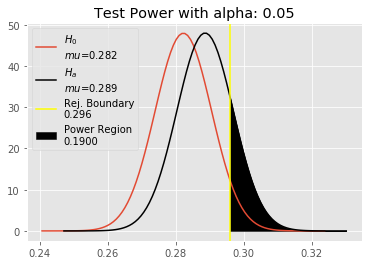

<Figure size 2160x2160 with 0 Axes>

In [108]:
plot_power(rnd_data, sma_data, alpha=0.05, one_tailed=True, figsize=(30,30))

Diff. in means: 0.006
Sample sizes: 
	H0 54000
	HA 54000
Standard Errors: 
	H0 0.00194
	HA 0.00195


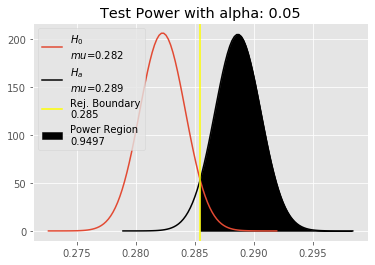

<Figure size 2160x2160 with 0 Axes>

In [109]:
plot_power(rnd_data, sma_data, force_n=54000, alpha=0.05, one_tailed=True, figsize=(30,30))